In [1]:
import tensorflow as tf
import numpy as np
import os
#from PhasedLSTMCell_v1 import *
#from PhasedLSTMCell import *
import time
import sys
import pickle
from rnn_dynamic import *
#from rnn_attentional import * #For the attentional experiment
import scipy
from scipy import spatial
import pandas as pd
import pylab as plt
import seaborn as sns

In [2]:
checkpoint_path = 'checkpoints/retrained/rep0-lstm2-256-1-128-adam-10000000000-20170519-171108/last_model/last_model.ckpt-29587200'
max_interactions = 100


# tensorflow model
model_parameters = {}
model_parameters['opt'] = 'adam'
model_parameters['learning_rate'] = 0.01
model_parameters['n_hidden'] = 256
model_parameters['batch_size'] = 128
model_parameters['rnn_type'] = 'lstm2'
model_parameters['rnn_layers'] = 1
model_parameters['dropout'] = 0.0
model_parameters['l2_reg'] = 0.0
model_parameters['type_output'] = 'softmax'
model_parameters['max_steps'] = 3000000
model_parameters['padding'] = 'right'
model_parameters['embedding_size'] = 64
model_parameters['embedding_activation'] = 'linear'
model_parameters['y_length'] = 1
model_parameters['W_emb_init'] = 'W_emb_64'
type_input = 'one-hot'
input_embeddings_size = 0
# Parameters for the attentional model only
model_parameters['attentional_layer'] = 'hidden_state'
model_parameters['attention_weights_activation'] = 'linear'
model_parameters['init_stdev'] = 0.1

model_parameters['n_input'] = 10057
model_parameters['n_output'] = 10057
model_parameters['seq_length'] = max_interactions

model = RNN_dynamic(model_parameters)
model.create_model()

Defined pretrained w_emb
Defined linear embedding


/home/ubuntu/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:91: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [5]:
for v in tf.trainable_variables():
    print(v.name)

w_out:0
b_out:0
w_emb:0
rnn/lstm_cell/weights:0
rnn/lstm_cell/biases:0


In [3]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)
    for v in tf.trainable_variables():
        if v.name == 'w_emb:0':
            print(v.name)
            w_emb = sess.run(v)  
            print(w_emb.shape)
            print(w_emb) # will show you your variable.

w_emb:0
(10057, 64)
[[-1.22363794  0.81352639  3.96503282 ..., -4.62381029  0.86838949
  -2.4336071 ]
 [-1.31774211  0.87973332  0.87265742 ..., -1.30478537 -0.29944816
   2.49424815]
 [ 1.05626237  1.63356471  1.12182498 ...,  0.59694916 -0.6508441
  -4.41053772]
 ..., 
 [-2.4263761  -1.79183173 -0.93973333 ...,  0.56499338  0.34849036
   1.50286019]
 [ 0.43055114 -1.42297769  0.97185516 ...,  1.69832063  1.13833249
  -0.01542331]
 [-0.45966893 -0.29862013  2.10825419 ...,  1.38837969  0.45070627
  -1.10684013]]


# Load movies dataset

In [4]:
start_date_train = '2009-01-01'
date_test = '2014-10-01'
min_seq_length = 5
max_seq_length = 100
movies_min_ratings = 20

#Ratings .dat format: UserID::MovieID::Rating::Timestamp
user_ids = []
movie_ids = []
ratings = []
timestamps = []
dataset_file = "../data/Movielens/ml-20m/ratings.csv"
df = pd.read_csv(dataset_file)
df['userId'] = df['userId'].astype(np.int32)
df['movieId'] = df['movieId'].astype(np.int32)
df['rating'] = df['rating'].astype(np.float16)
df['date'] = pd.to_datetime(df['timestamp'],unit='s')

df_date = df[df.date > start_date_train]

# Filter out movies with less than X ratings
filter_movies = df_date.movieId.value_counts()[(df_date.movieId.value_counts() > movies_min_ratings)].index.values
df_date = df_date[df_date.movieId.isin(filter_movies)]
print('Total number of ratings:' + str(len(df_date)))
print('Number of different users: ' + str(len(df_date['userId'].unique())))
print('Number of different movies: ' + str(len(df_date['movieId'].unique())))
sys.stdout.flush()
# Filter out users with less than X ratings
filter_users = df_date['userId'].value_counts()[(df_date['userId'].value_counts() >= min_seq_length)].index.values
df_date = df_date[df_date.userId.isin(filter_users)]
print('Total number of ratings:' + str(len(df_date)))
print('Number of different users: ' + str(len(df_date['userId'].unique())))
print('Number of different movies: ' + str(len(df_date['movieId'].unique())))

# Build array mapping movie_id --> position in one-hot encoding
movieIds = np.zeros(max(df_date['movieId'].unique()) + 1, np.uint16)
i = 0
for movieId in df_date['movieId'].unique():
    movieIds[movieId] = i
    i += 1

dataset_file = "../data/Movielens/ml-20m/movies.csv"
df_movies = pd.read_csv(dataset_file)
print(len(df_movies.movieId.unique()))
df_movies = df_movies[df_movies.movieId.isin(df_date.movieId.unique())]
print(len(df_movies.movieId.unique()))

# Preprocess year
years = []
for movie_title in df_movies.title:
    year = movie_title[movie_title.find("(")+1:movie_title.find(")")]
    if not year.isdigit():
        year = 0
    years.append(int(year))
df_movies['year'] = years

Total number of ratings:4687202
Number of different users: 36395
Number of different movies: 10057
Total number of ratings:4685946
Number of different users: 35821
Number of different movies: 10057
27278
10057


In [5]:
# Create dictionary dict_movie[position one-hot] = id movilens data set
dict_movies = {}
for i in range(len(movieIds)):
    if movieIds[i] != 0:
        dict_movies[movieIds[i]] = i
dict_movies[0] = 1 # Manually entry, as many items in the array are 0, but this is the one which belongs to an item id

In [6]:
dict_movies[2]

19

In [7]:
i = 0
for movieId in df_date['movieId'].unique():
    print(movieId)
    i += 1
    if i == 10:
        break

1
10
19
32
39
65
110
145
150
153


# T-SNE and PCA Visualizations

In [8]:
# Train T-SNE with all the data
from sklearn.manifold import TSNE

data_tsne = []
movies_ids_sorted = []
for i in range(len(w_emb)):
    data_tsne.append(w_emb[i,:])
    movies_ids_sorted.append(dict_movies[i])

    
data_tsne = np.array(data_tsne)
print(data_tsne.shape)
model_tsn_all = TSNE(n_components=2, random_state=17)
Y_tsn_all = model_tsn_all.fit_transform(data_tsne)

# Create data frame
df_tsne = pd.concat([pd.DataFrame(Y_tsn_all),
                pd.Series(movies_ids_sorted)],
               axis=1)

df_tsne.columns = ['x', 'y', 'movie_id']

titles = []
genres = []
years = []
for movie_id in df_tsne.movie_id:
    titles.append(df_movies[df_movies.movieId == int(movie_id)].title.values[0])
    genres.append(df_movies[df_movies.movieId == int(movie_id)].genres.values[0])
    years.append(df_movies[df_movies.movieId == int(movie_id)].year.values[0])
df_tsne['title'] = titles
df_tsne['genres'] = genres
df_tsne['years'] = years

(10057, 64)


In [9]:
# Train PCA with all the data
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(data_tsne)
X_pca_all = pca.transform(data_tsne)

# Create data frame
df_pca = pd.concat([pd.DataFrame(X_pca_all),
                pd.Series(movies_ids_sorted)],
               axis=1)

df_pca.columns = ['x', 'y', 'movie_id']

titles = []
genres = []
years = []
for movie_id in df_pca.movie_id:
    titles.append(df_movies[df_movies.movieId == int(movie_id)].title.values[0])
    genres.append(df_movies[df_movies.movieId == int(movie_id)].genres.values[0])
    years.append(df_movies[df_movies.movieId == int(movie_id)].year.values[0])
    
df_pca['title'] = titles
df_pca['genres'] = genres
df_pca['years'] = years

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


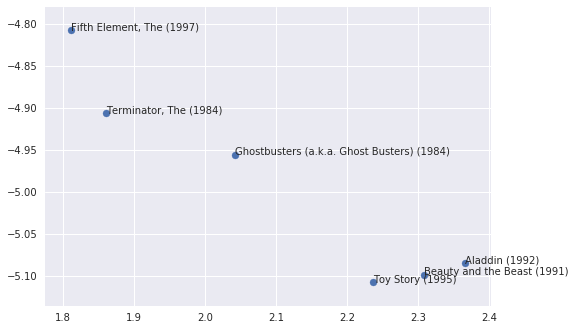

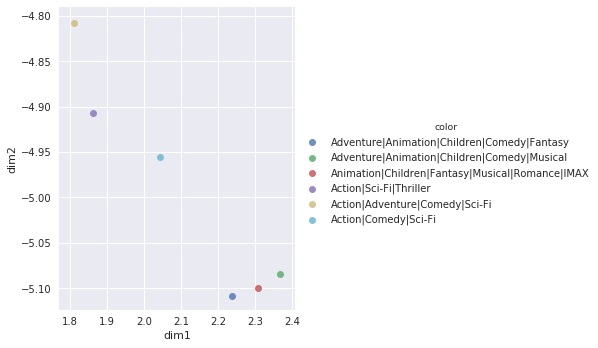

In [10]:
# Visualize n random examples with tsne with annotations
df_show = df_tsne.sample(n=10)

# Visualize specific movies 1(Toy Story), 595(Beautry and Beast), 588(Aladin), 1240(Terminator), 2985(Robocop),  
ids = [1, 595, 588, 1240, 2716, 1527]
ids = [i for i in ids]
df_show = df_tsne[df_tsne.movie_id.isin(ids)]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df_show['x'], df_show['y'])

for i, txt in enumerate(df_show['title']):
    ax.annotate(txt, (df_show['x'].iloc[i], df_show['y'].iloc[i]), fontsize=10)
fig.savefig('scatter_annotations.png')
plt.show()

df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=df_show['genres']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.show()

# Plot per year (old/new)

In [15]:
df_tsne['year_category'] = 'Null'
df_tsne.loc[(df_tsne.years > 1900) & (df_tsne.years < 1970),'year_category'] = 'Old (1900-1970)'
#df_tsne.loc[(df_tsne.years > 1950) & (df_tsne.years < 2000),'year_category'] = '1950-1990'
df_tsne.loc[(df_tsne.years > 2000),'year_category'] = 'New (2000 or newer)'

df_pca['year_category'] = 'Null'
df_pca.loc[(df_pca.years > 1900) & (df_pca.years < 1970),'year_category'] = 'Old (1900-1970)'
#df_pca.loc[(df_pca.years > 1950) & (df_pca.years < 2000),'year_category'] = '1950-2000'
df_pca.loc[(df_pca.years > 2000),'year_category'] = 'New (2000 or newer)'

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


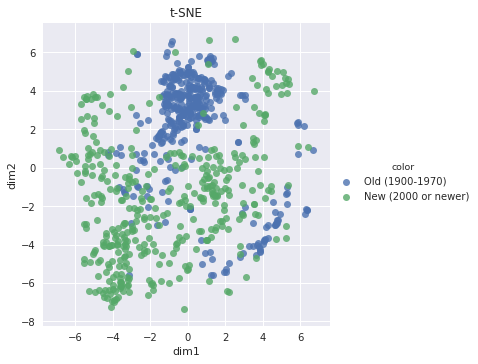

In [16]:
# Using the tsne with all the data
n_samples = 400
df_show1 = df_tsne[df_tsne.year_category == 'Old (1900-1970)'].sample(n=n_samples)
#df_show2 = df_tsne[df_tsne.year_category == '1950-1990'].sample(n=n_samples)
df_show3 = df_tsne[df_tsne.year_category == 'New (2000 or newer)'].sample(n=n_samples)
df_show = pd.concat([df_show1, df_show3])

#fig = plt.figure()
#ax = fig.add_subplot(1, 1, 1)

#ax.scatter(df_show['x'], df_show['y'])

#for i, txt in enumerate(df_show['year_category']):
    #ax.annotate(txt, (df_show['x'].iloc[i], df_show['y'].iloc[i]))
#fig.savefig('scatter_annotations.png')
#plt.show()

df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=df_show['year_category']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('t-SNE')
plt.show()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


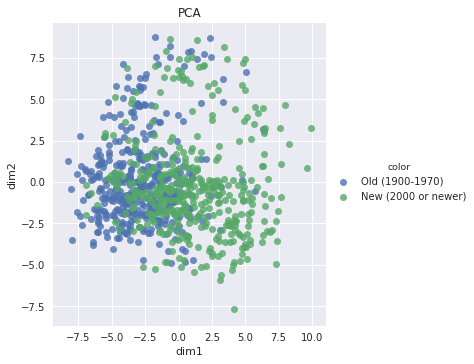

In [17]:
# Using the pca with all the data
n_samples = 400
df_show1 = df_pca[df_pca.year_category == 'Old (1900-1970)'].sample(n=n_samples)
#df_show2 = df_pca[df_pca.year_category == '1960-1990'].sample(n=n_samples)
df_show3 = df_pca[df_pca.year_category == 'New (2000 or newer)'].sample(n=n_samples)
df_show = pd.concat([df_show1, df_show3])

#fig = plt.figure()
#ax = fig.add_subplot(1, 1, 1)

#ax.scatter(df_show['x'], df_show['y'])

#for i, txt in enumerate(df_show['year_category']):
    #ax.annotate(txt, (df_show['x'].iloc[i], df_show['y'].iloc[i]))
#fig.savefig('scatter_annotations.png')
#plt.show()

df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=df_show['year_category']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('PCA')
plt.show()

(800, 64)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


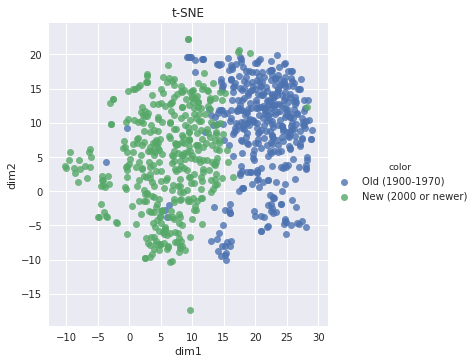

In [18]:
# Recomputing tsne for the selected samples
n_samples = 400
df_show1 = df_tsne[df_tsne.year_category == 'Old (1900-1970)'].sample(n=n_samples)
#df_show2 = df_tsne[df_tsne.year_category == '1950-1990'].sample(n=n_samples)
df_show3 = df_tsne[df_tsne.year_category == 'New (2000 or newer)'].sample(n=n_samples)
df_show = pd.concat([df_show1, df_show3])

item_vectors = []
for movie_id in df_show.movie_id:
    position = movieIds[movie_id]
    vector = w_emb[position,:]
    item_vectors.append(vector)
    
item_vectors = np.array(item_vectors)    
print(item_vectors.shape)

model_tsn_1 = TSNE(n_components=2, random_state=8)
Y_tsn_1 = model_tsn_1.fit_transform(item_vectors)


df_show['x_1'] = Y_tsn_1[:, 0]
df_show['y_1'] = Y_tsn_1[:, 1]


df_plot = pd.DataFrame(dict(dim1=df_show['x_1'], dim2=df_show['y_1'], color=df_show['year_category']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('t-SNE')
plt.show()

(800, 64)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


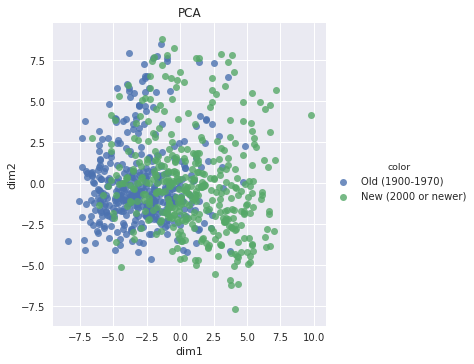

In [19]:
# Recomputing pca for the selected samples
n_samples = 400
df_show1 = df_pca[df_pca.year_category == 'Old (1900-1970)'].sample(n=n_samples)
#df_show2 = df_pca[df_pca.year_category == '1960-1990'].sample(n=n_samples)
df_show3 = df_pca[df_pca.year_category == 'New (2000 or newer)'].sample(n=n_samples)
df_show = pd.concat([df_show1, df_show3])

item_vectors = []
for movie_id in df_show.movie_id:
    position = movieIds[movie_id]
    vector = w_emb[position,:]
    item_vectors.append(vector)
    
item_vectors = np.array(item_vectors)    
print(item_vectors.shape)

X_pca_1 = PCA(n_components=2)
X_pca_1.fit(item_vectors)
X_pca_1 = pca.transform(item_vectors)


df_show['x_1'] = X_pca_1[:, 0]
df_show['y_1'] = X_pca_1[:, 1]


df_plot = pd.DataFrame(dict(dim1=df_show['x_1'], dim2=df_show['y_1'], color=df_show['year_category']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('PCA')
plt.show()

In [20]:
romance_genres = ['Comedy|Romance', 'Comedy|Musical|Romance', 'Musical|Romance', 'Fantasy|Musical|Romance', 'Romance', 'Comedy|Romance|Thriller',
                'Fantasy|Romance', 'Drama|Romance']
children_genres = ['Animation|Children|Fantasy', 'Action|Animation|Children|Comedy', 'Adventure|Animation|Children|Fantasy',
                  'Animation|Children', 'Adventure|Children|Fantasy', 'Action|Animation|Children', 'Adventure|Children',
                  'Adventure|Animation|Children', 'Children|Comedy|Fantasy', 'Children|Fantasy', 'Action|Children',
                  'Action|Children|Fantasy', 'Children', 'Animation|Children|Fantasy|IMAX', 'Action|Adventure|Children|IMAX',
                  'Adventure|Children|Comedy|Fantasy|Mystery', 'Adventure|Children|Drama|Fantasy', 'Animation|Children|Fantasy|IMAX',
                  'Children|Comedy']
horror_genres = ['Horror|Mystery|Thriller', 'Horror', 'Horror|Thriller', 'Action|Horror', 'Drama|Horror|Thriller'
                'Drama|Horror', 'Crime|Horror|Thriller', 'Action|Crime|Horror', 'Crime|Horror', 'Crime|Horror|Mystery'
                'Crime|Drama|Horror', ]

In [21]:
df_tsne['genre_1'] = 'Null'
df_tsne.loc[df_tsne.genres.isin(romance_genres), 'genre_1'] = 'Romance'
df_tsne.loc[df_tsne.genres.isin(children_genres), 'genre_1'] = 'Children'
df_tsne.loc[df_tsne.genres.isin(horror_genres), 'genre_1'] = 'Horror'


df_pca['genre_1'] = 'Null'
df_pca.loc[df_pca.genres.isin(romance_genres), 'genre_1'] = 'Romance'
df_pca.loc[df_pca.genres.isin(children_genres), 'genre_1'] = 'Children'
df_pca.loc[df_pca.genres.isin(horror_genres), 'genre_1'] = 'Horror'

In [22]:
print(len(df_tsne[df_tsne.genre_1 == 'Romance']))
print(len(df_tsne[df_tsne.genre_1 == 'Children']))
print(len(df_tsne[df_tsne.genre_1 == 'Horror']))

820
212
415


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


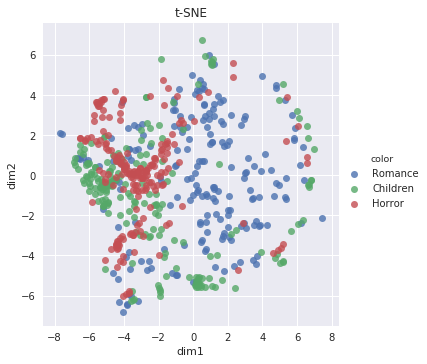

In [23]:
# Using the tsne with all the data
n_samples = 200
df_show1 = df_tsne[df_tsne.genre_1 == 'Romance'].sample(n=n_samples)
df_show2 = df_tsne[df_tsne.genre_1 == 'Children'].sample(n=n_samples)
df_show3 = df_tsne[df_tsne.genre_1 == 'Horror'].sample(n=n_samples)
df_show = pd.concat([df_show1, df_show2, df_show3])


df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=df_show['genre_1']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('t-SNE')
plt.show()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


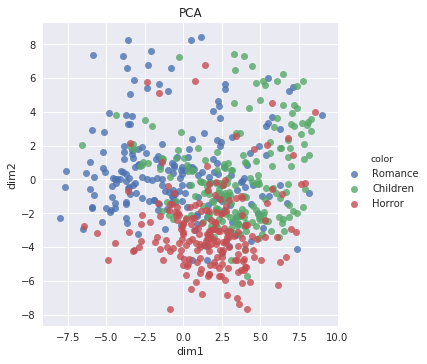

In [24]:
# Using the pca with all the data
n_samples = 200
df_show1 = df_pca[df_tsne.genre_1 == 'Romance'].sample(n=n_samples)
df_show2 = df_pca[df_tsne.genre_1 == 'Children'].sample(n=n_samples)
df_show3 = df_pca[df_tsne.genre_1 == 'Horror'].sample(n=n_samples)
df_show = pd.concat([df_show1, df_show2, df_show3])


df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=df_show['genre_1']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('PCA')
plt.show()

(600, 64)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


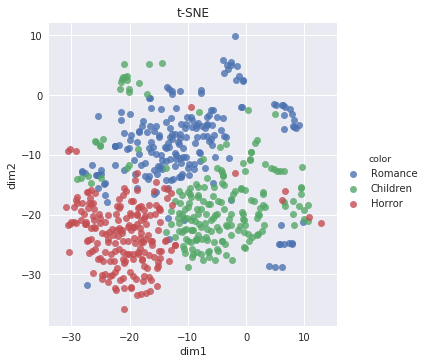

In [25]:
# Recomputing tsne for the selected samples
n_samples = 200
df_show1 = df_tsne[df_tsne.genre_1 == 'Romance'].sample(n=n_samples)
df_show2 = df_tsne[df_tsne.genre_1 == 'Children'].sample(n=n_samples)
df_show3 = df_tsne[df_tsne.genre_1 == 'Horror'].sample(n=n_samples)
df_show = pd.concat([df_show1, df_show2, df_show3])

item_vectors = []
for movie_id in df_show.movie_id:
    position = movieIds[movie_id]
    vector = w_emb[position,:]
    item_vectors.append(vector)
    
item_vectors = np.array(item_vectors)    
print(item_vectors.shape)

model_tsn_1 = TSNE(n_components=2, random_state=8)
Y_tsn_1 = model_tsn_1.fit_transform(item_vectors)


df_show['x_1'] = Y_tsn_1[:, 0]
df_show['y_1'] = Y_tsn_1[:, 1]


df_plot = pd.DataFrame(dict(dim1=df_show['x_1'], dim2=df_show['y_1'], color=df_show['genre_1']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('t-SNE')
plt.show()

(600, 64)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


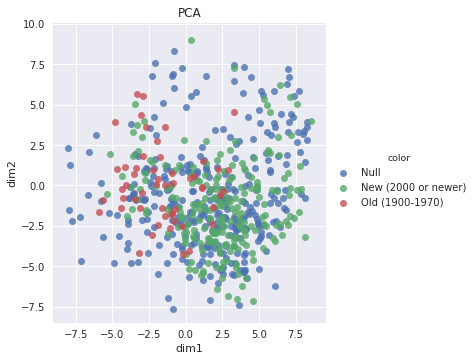

In [26]:
# Recomputing pca for the selected samples
n_samples = 200
df_show1 = df_pca[df_tsne.genre_1 == 'Romance'].sample(n=n_samples)
df_show2 = df_pca[df_tsne.genre_1 == 'Children'].sample(n=n_samples)
df_show3 = df_pca[df_tsne.genre_1 == 'Horror'].sample(n=n_samples)
df_show = pd.concat([df_show1, df_show2, df_show3])

item_vectors = []
for movie_id in df_show.movie_id:
    position = movieIds[movie_id]
    vector = w_emb[position,:]
    item_vectors.append(vector)
    
item_vectors = np.array(item_vectors)    
print(item_vectors.shape)

X_pca_1 = PCA(n_components=2)
X_pca_1.fit(item_vectors)
X_pca_1 = pca.transform(item_vectors)


df_show['x_1'] = X_pca_1[:, 0]
df_show['y_1'] = X_pca_1[:, 1]


df_plot = pd.DataFrame(dict(dim1=df_show['x_1'], dim2=df_show['y_1'], color=df_show['year_category']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('PCA')
plt.show()

# Plot one Genre vs Other

In [27]:
# Drama vs Comedy 

drama_genres = ['Drama', 'Action|Crime|Drama', 'Drama|War', 'Crime|Drama', 'Drama|Thriller', 'Adventure|Drama',
               'Crime|Drama|Mystery', 'Drama|Mystery', 'Action|Drama|War', 'Drama|Thriller|War']
comedy_genres = ['Adventure|Comedy', 'Comedy|Romance', 'Comedy', 'Children|Comedy', 'Action|Comedy', 'Animation|Comedy',
                'Action|Comedy|IMAX']


df_tsne['genre_2'] = 'Null'
df_tsne.loc[df_tsne.genres.isin(drama_genres), 'genre_2'] = 'Drama'
df_tsne.loc[df_tsne.genres.isin(comedy_genres), 'genre_2'] = 'Comedy'



df_pca['genre_2'] = 'Null'
df_pca.loc[df_pca.genres.isin(drama_genres), 'genre_2'] = 'Drama'
df_pca.loc[df_pca.genres.isin(comedy_genres), 'genre_2'] = 'Comedy'

In [28]:
#for genre in df_pca.genres.unique():
    #if 'Comedy' in genre:
        #print(genre)

print(len(df_tsne[df_tsne.genre_2 == 'Drama']))
print(len(df_tsne[df_tsne.genre_2 == 'Comedy']))

1909
1314


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


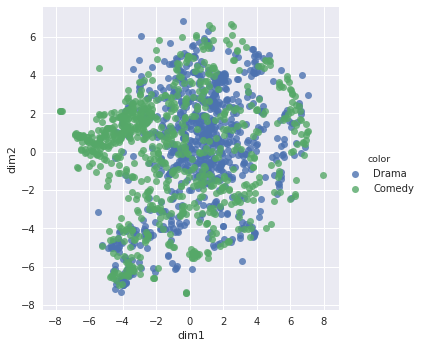

In [29]:
# Using the tsne with all the data
n_samples = 800
df_show1 = df_tsne[df_tsne.genre_2 == 'Drama'].sample(n=n_samples)
df_show2 = df_tsne[df_tsne.genre_2 == 'Comedy'].sample(n=n_samples)
df_show = pd.concat([df_show1, df_show2])


df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=df_show['genre_2']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.show()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


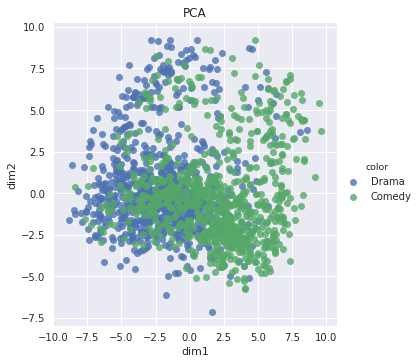

In [30]:
# Using the pca with all the data
n_samples = 800
df_show1 = df_pca[df_tsne.genre_2 == 'Drama'].sample(n=n_samples)
df_show2 = df_pca[df_tsne.genre_2 == 'Comedy'].sample(n=n_samples)
df_show = pd.concat([df_show1, df_show2])


df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=df_show['genre_2']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('PCA')
plt.show()

(1600, 64)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


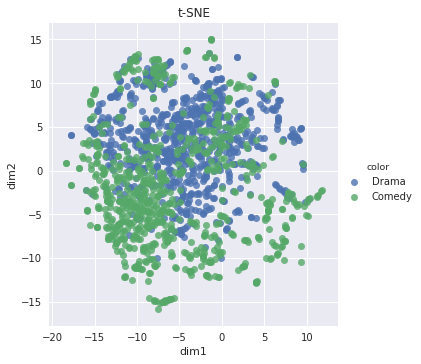

In [31]:
# Recomputing tsne for the selected samples
n_samples = 800
df_show1 = df_tsne[df_tsne.genre_2 == 'Drama'].sample(n=n_samples)
df_show2 = df_tsne[df_tsne.genre_2 == 'Comedy'].sample(n=n_samples)
df_show = pd.concat([df_show1, df_show2])

item_vectors = []
for movie_id in df_show.movie_id:
    position = movieIds[movie_id]
    vector = w_emb[position,:]
    item_vectors.append(vector)
    
item_vectors = np.array(item_vectors)    
print(item_vectors.shape)

model_tsn_1 = TSNE(n_components=2, random_state=8)
Y_tsn_1 = model_tsn_1.fit_transform(item_vectors)


df_show['x_1'] = Y_tsn_1[:, 0]
df_show['y_1'] = Y_tsn_1[:, 1]


df_plot = pd.DataFrame(dict(dim1=df_show['x_1'], dim2=df_show['y_1'], color=df_show['genre_2']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('t-SNE')
plt.show()

(1600, 64)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


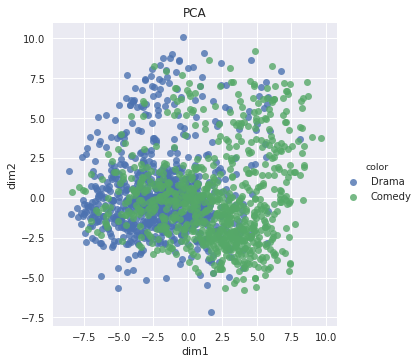

In [32]:
# Recomputing pca for the selected samples
n_samples = 800
df_show1 = df_pca[df_tsne.genre_2 == 'Drama'].sample(n=n_samples)
df_show2 = df_pca[df_tsne.genre_2 == 'Comedy'].sample(n=n_samples)
df_show = pd.concat([df_show1, df_show2])

item_vectors = []
for movie_id in df_show.movie_id:
    position = movieIds[movie_id]
    vector = w_emb[position,:]
    item_vectors.append(vector)
    
item_vectors = np.array(item_vectors)    
print(item_vectors.shape)

X_pca_1 = PCA(n_components=2)
X_pca_1.fit(item_vectors)
X_pca_1 = pca.transform(item_vectors)


df_show['x_1'] = X_pca_1[:, 0]
df_show['y_1'] = X_pca_1[:, 1]


df_plot = pd.DataFrame(dict(dim1=df_show['x_1'], dim2=df_show['y_1'], color=df_show['genre_2']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('PCA')
plt.show()

# Plots more concrete genres

In [33]:
# War vs Musical 

drama_war_action_genres = ['Drama|War', 'Action|Drama|War']
comedy_romance_genres = ['Comedy|Drama|Romance']
children_comedy = ['Children|Comedy', 'Children|Comedy|Fantasy']
western_genres = ['Western']


df_tsne['genre_3'] = 'Null'
df_tsne.loc[df_tsne.genres.isin(drama_war_action_genres), 'genre_3'] = 'Drama|War|Action'
df_tsne.loc[df_tsne.genres.isin(comedy_romance_genres), 'genre_3'] = 'Comedy|Romance'
df_tsne.loc[df_tsne.genres.isin(children_comedy), 'genre_3'] = 'Children|Comedy'
df_tsne.loc[df_tsne.genres.isin(western_genres), 'genre_3'] = 'Western'



df_pca['genre_3'] = 'Null'
df_pca.loc[df_pca.genres.isin(drama_war_action_genres), 'genre_3'] = 'Drama|War|Action'
df_pca.loc[df_pca.genres.isin(comedy_romance_genres), 'genre_3'] = 'Comedy|Romance'
df_pca.loc[df_pca.genres.isin(children_comedy), 'genre_3'] = 'Children|Comedy'
df_pca.loc[df_pca.genres.isin(western_genres), 'genre_3'] = 'Western'

In [34]:
print(len(df_tsne[df_tsne.genre_3 == 'Drama|War|Action']))
print(len(df_tsne[df_tsne.genre_3 == 'Comedy|Romance']))
print(len(df_tsne[df_tsne.genre_3 == 'Children|Comedy']))
print(len(df_tsne[df_tsne.genre_3 == 'Western']))

192
292
94
41


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


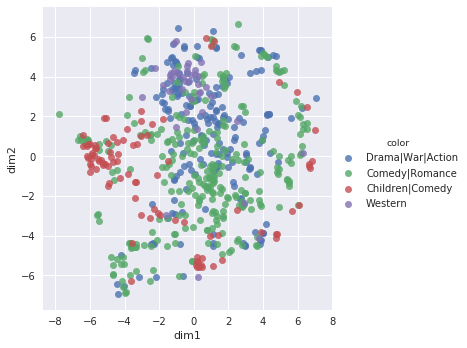

In [35]:
# Using the tsne with all the data
n_samples = 40
df_show1 = df_tsne[df_tsne.genre_3 == 'Drama|War|Action'].sample(n=192)
df_show2 = df_tsne[df_tsne.genre_3 == 'Comedy|Romance'].sample(n=292)
df_show3 = df_tsne[df_tsne.genre_3 == 'Children|Comedy'].sample(n=94)
df_show4 = df_tsne[df_tsne.genre_3 == 'Western'].sample(n=41)
df_show = pd.concat([df_show1, df_show2 ,df_show3, df_show4])


df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=df_show['genre_3']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.show()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


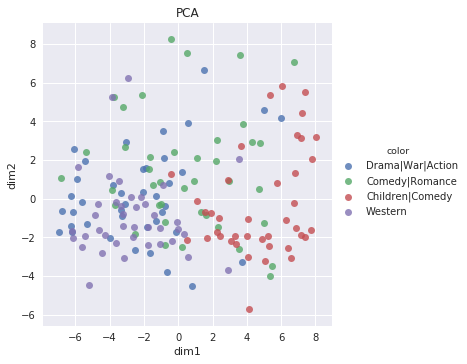

In [36]:
# Using the pca with all the data
n_samples = 40
df_show1 = df_pca[df_pca.genre_3 == 'Drama|War|Action'].sample(n=n_samples)
df_show2 = df_pca[df_pca.genre_3 == 'Comedy|Romance'].sample(n=n_samples)
df_show3 = df_pca[df_pca.genre_3 == 'Children|Comedy'].sample(n=n_samples)
df_show4 = df_pca[df_pca.genre_3 == 'Western'].sample(n=n_samples)
df_show = pd.concat([df_show1, df_show2 ,df_show3, df_show4])


df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=df_show['genre_3']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('PCA')
plt.show()

(619, 64)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


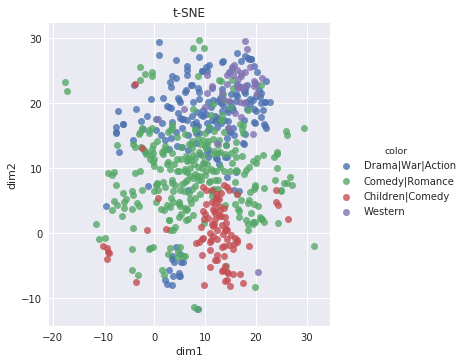

In [37]:
# Recomputing tsne for the selected samples
n_samples = 40
df_show1 = df_tsne[df_tsne.genre_3 == 'Drama|War|Action'].sample(n=192)
df_show2 = df_tsne[df_tsne.genre_3 == 'Comedy|Romance'].sample(n=292)
df_show3 = df_tsne[df_tsne.genre_3 == 'Children|Comedy'].sample(n=94)
df_show4 = df_tsne[df_tsne.genre_3 == 'Western'].sample(n=41)
df_show = pd.concat([df_show1, df_show2 ,df_show3, df_show4])

item_vectors = []
for movie_id in df_show.movie_id:
    position = movieIds[movie_id]
    vector = w_emb[position,:]
    item_vectors.append(vector)
    
item_vectors = np.array(item_vectors)    
print(item_vectors.shape)

model_tsn_1 = TSNE(n_components=2, random_state=8)
Y_tsn_1 = model_tsn_1.fit_transform(item_vectors)


df_show['x_1'] = Y_tsn_1[:, 0]
df_show['y_1'] = Y_tsn_1[:, 1]


df_plot = pd.DataFrame(dict(dim1=df_show['x_1'], dim2=df_show['y_1'], color=df_show['genre_3']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('t-SNE')
plt.show()

(160, 64)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


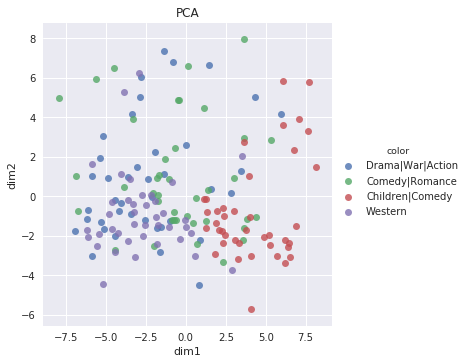

In [38]:
# Recomputing pca for the selected samples
n_samples = 40
df_show1 = df_pca[df_pca.genre_3 == 'Drama|War|Action'].sample(n=n_samples)
df_show2 = df_pca[df_pca.genre_3 == 'Comedy|Romance'].sample(n=n_samples)
df_show3 = df_pca[df_pca.genre_3 == 'Children|Comedy'].sample(n=n_samples)
df_show4 = df_pca[df_pca.genre_3 == 'Western'].sample(n=n_samples)
df_show = pd.concat([df_show1, df_show2 ,df_show3, df_show4])

item_vectors = []
for movie_id in df_show.movie_id:
    position = movieIds[movie_id]
    vector = w_emb[position,:]
    item_vectors.append(vector)
    
item_vectors = np.array(item_vectors)    
print(item_vectors.shape)

X_pca_1 = PCA(n_components=2)
X_pca_1.fit(item_vectors)
X_pca_1 = pca.transform(item_vectors)


df_show['x_1'] = X_pca_1[:, 0]
df_show['y_1'] = X_pca_1[:, 1]


df_plot = pd.DataFrame(dict(dim1=df_show['x_1'], dim2=df_show['y_1'], color=df_show['genre_3']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('PCA')
plt.show()

# Plots for specific Movies

In [11]:
df_tsne['movie_id'] = df_tsne['movie_id'].astype(str) 
df_pca['movie_id'] = df_pca['movie_id'].astype(str)

In [40]:
# Find movie
df_tsne[df_tsne.title.str.contains('Scream')]

,x,y,movie_id,title,genres,years,year_category,genre_1,genre_2,genre_3
1510,1.076633,-5.343812,1407,Scream (1996),Comedy|Horror|Mystery|Thriller,1996,Null,Null,Null,Null
1650,6.976012,1.455879,1717,Scream 2 (1997),Comedy|Horror|Mystery|Thriller,1997,Null,Null,Null,Null
2591,-3.982629,-0.126666,76,Screamers (1995),Action|Sci-Fi|Thriller,1995,Null,Null,Null,Null
2633,6.956392,1.296762,3273,Scream 3 (2000),Comedy|Horror|Mystery|Thriller,2000,Null,Null,Null,Null
3532,-3.609476,-2.890734,86295,Scream 4 (2011),Comedy|Horror|Mystery|Thriller,2011,New (2000 or newer),Null,Null,Null
4109,-5.350497,0.671139,33495,Kicking & Screaming (2005),Comedy,2005,New (2000 or newer),Null,Comedy,Null
4110,-3.041862,-0.440173,33930,Man with the Screaming Brain (2005),Adventure|Comedy|Sci-Fi,2005,New (2000 or newer),Null,Null,Null
4284,-4.327766,0.641620,66789,Screamers: The Hunting (2009),Sci-Fi|Thriller,2009,New (2000 or newer),Null,Null,Null
6417,0.774845,-1.320881,72,Kicking and Screaming (1995),Comedy|Drama,1995,Null,Null,Null,Null


In [41]:
# Some sagas

star_wars_movies = [260, 1196, 1210, 2628, 5378, 33493]
lord_of_the_rings_movies = [4993, 5952, 7153, 106489, 98809, 118696]
saw_movies = [8957, 39446, 48877, 55577, 63436, 72129, 81535]
#toy_story_movies = [78499, 3114, 1]
rocky_movies = [1954, 2409, 2410, 2411, 2412, 89045]
harry_potter_movies = [81834, 88125, 8368, 4896, 54001, 69844, 40815, 5816]
scream_movies = [86295, 1407, 1717, 3273]
star_wars_movies = [str(i) for i in star_wars_movies]
lord_of_the_rings_movies = [str(i) for i in lord_of_the_rings_movies]
saw_movies = [str(i) for i in saw_movies]
#toy_story_movies = [str(i) for i in toy_story_movies]
rocky_movies = [str(i) for i in rocky_movies]
harry_potter_movies = [str(i) for i in harry_potter_movies]
scream_movies = [str(i) for i in scream_movies]



df_tsne['saga'] = 'Null'
df_tsne.loc[df_tsne.movie_id.isin(star_wars_movies), 'saga'] = 'Star Wars'
df_tsne.loc[df_tsne.movie_id.isin(lord_of_the_rings_movies), 'saga'] = 'Lord of the Rings'
df_tsne.loc[df_tsne.movie_id.isin(saw_movies), 'saga'] = 'Saw'
#df_tsne.loc[df_tsne.movie_id.isin(toy_story_movies), 'saga'] = 'Toy Story'
df_tsne.loc[df_tsne.movie_id.isin(rocky_movies), 'saga'] = 'Rocky'
df_tsne.loc[df_tsne.movie_id.isin(harry_potter_movies), 'saga'] = 'Harry Potter'
df_tsne.loc[df_tsne.movie_id.isin(scream_movies), 'saga'] = 'Scream'



df_pca['saga'] = 'Null'
df_pca.loc[df_pca.movie_id.isin(star_wars_movies), 'saga'] = 'Star Wars'
df_pca.loc[df_pca.movie_id.isin(lord_of_the_rings_movies), 'saga'] = 'Lord of the Rings'
df_pca.loc[df_pca.movie_id.isin(saw_movies), 'saga'] = 'Saw'
#df_pca.loc[df_pca.movie_id.isin(toy_story_movies), 'saga'] = 'Toy Story'
df_pca.loc[df_pca.movie_id.isin(rocky_movies), 'saga'] = 'Rocky'
df_pca.loc[df_pca.movie_id.isin(harry_potter_movies), 'saga'] = 'Harry Potter'
df_pca.loc[df_pca.movie_id.isin(scream_movies), 'saga'] = 'Scream'


len_star_wars = len(df_tsne[df_tsne.saga == 'Star Wars'])
len_lord_of_the_rings = len(df_tsne[df_tsne.saga == 'Lord of the Rings'])
len_saw = len(df_tsne[df_tsne.saga == 'Saw'])
#len_toy_story = len(df_tsne[df_tsne.saga == 'Toy Story'])
len_rocky = len(df_tsne[df_tsne.saga == 'Rocky'])
len_harrypotter = len(df_tsne[df_tsne.saga == 'Harry Potter'])
len_scream = len(df_tsne[df_tsne.saga == 'Scream'])
print(len_star_wars)
print(len_lord_of_the_rings)
print(len_saw)
#print(len_toy_story)
print(len_rocky)
print(len_harrypotter)
print(len_scream)

6
6
7
6
8
4


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


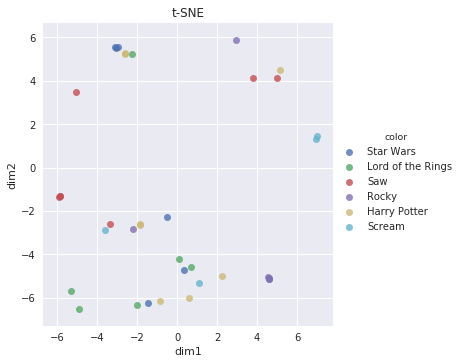

In [42]:
# Using the tsne with all the data
n_samples = 40
df_show1 = df_tsne[df_tsne.saga == 'Star Wars'].sample(n=len_star_wars)
df_show2 = df_tsne[df_tsne.saga == 'Lord of the Rings'].sample(n=len_lord_of_the_rings)
df_show3 = df_tsne[df_tsne.saga == 'Saw'].sample(n=len_saw)
#df_show4 = df_tsne[df_tsne.saga == 'Toy Story'].sample(n=len_toy_story)
df_show5 = df_tsne[df_tsne.saga == 'Rocky'].sample(n=len_rocky)
df_show6 = df_tsne[df_tsne.saga == 'Harry Potter'].sample(n=len_harrypotter)
df_show7 = df_tsne[df_tsne.saga == 'Scream'].sample(n=len_scream)
df_show = pd.concat([df_show1, df_show2 ,df_show3, df_show5, df_show6, df_show7])


df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=df_show['saga']))
ax = sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('t-SNE')
plt.show()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


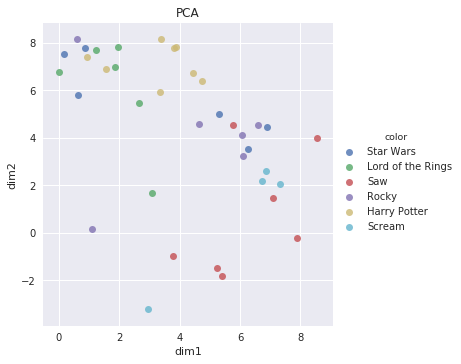

In [43]:
# Using the pca with all the data
n_samples = 40
df_show1 = df_pca[df_pca.saga == 'Star Wars'].sample(n=len_star_wars)
df_show2 = df_pca[df_pca.saga == 'Lord of the Rings'].sample(n=len_lord_of_the_rings)
df_show3 = df_pca[df_pca.saga == 'Saw'].sample(n=len_saw)
#df_show4 = df_pca[df_pca.saga == 'Toy Story'].sample(n=len_toy_story)
df_show5 = df_pca[df_pca.saga == 'Rocky'].sample(n=len_rocky)
df_show6 = df_pca[df_pca.saga == 'Harry Potter'].sample(n=len_harrypotter)
df_show7 = df_pca[df_pca.saga == 'Scream'].sample(n=len_scream)
df_show = pd.concat([df_show1, df_show2 ,df_show3, df_show5, df_show6, df_show7])


df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=df_show['saga']))
sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('PCA')
plt.show()

# Plot some of items that are in a windows size of 5 in order

In [421]:
def times_elements_in_seq_windows(all_sequences, sequence, windows_size):
    count = 0
    for seq in all_sequences:
        # Look if the first element is in the sequence
        if sequence[0] in seq:
            first_idx = seq.index(sequence[0])
            if len(seq) >= (first_idx+windows_size):
                seq_look = seq[first_idx:(first_idx+windows_size)]
                #print('seq_look: ' + str(seq_look))
                # Look the rest of the elements
                not_found = False
                for el in sequence:
                    #print(el)
                    if not el in seq_look:
                        not_found = True
                        break
                if not not_found:
                    count += 1
    return count


look = ['1', '2', '4']
ws = 4
all_sequences = [['1', '2', '3', '4', '5'], ['1', '2', '10', '11', '12' '4'], ['0', '1', '2', '4', '10']]                    
print(times_elements_in_seq_windows(all_sequences, look, ws))  
print('---------')
look = ['1', '8', '4']
all_sequences = [['1', '2', '3', '4', '5'], ['1', '2', '10', '11', '12' '4'], ['1', '2', '4']]                    
print(times_elements_in_seq_windows(all_sequences, look, ws))  
print('---------')
look = ['1', '2', '3']
all_sequences = [['1', '2', '3', '4', '5'], ['1', '2', '10', '11', '12' '4'], ['1', '2', '4']]                    
print(times_elements_in_seq_windows(all_sequences, look, ws))

2
---------
0
---------
1


In [399]:
movie_sequences[0][1:(1+5)]

['3396', '671', '44225', '2683', '34334']

In [377]:
# Create movie sequence
grouped = df_date.groupby('userId')

movie_sequences = []
i = 0
for name, group in grouped:
    # sorting by ratings
    movie_sequences.append(group.sort_values(['rating', 'date']).movieId.values.astype(str).tolist())
    i += 1

In [513]:
movie_id_look = '3578'
windows_size_side = 5
times_next = {}
times_previous = {}
for seq in movie_sequences:
    if movie_id_look in seq:
        idx = seq.index(movie_id_look)
        if (idx < (len(seq) - 3)) and (idx > 1):
            windows_movies_previous = seq[(idx-windows_size_side):idx]
            windows_movies_next = seq[(idx+1):(idx+1+windows_size_side)]
            for previous_movie in windows_movies_previous:
                if previous_movie in times_previous:
                    times_previous[previous_movie] += 1
                else:
                    times_previous[previous_movie] = 1
            for next_movie in windows_movies_next:
                if next_movie in times_next:
                    times_next[next_movie] += 1
                else:
                    times_next[next_movie] = 1
            
import operator
sorted_times_next = sorted(times_next.items(), key=operator.itemgetter(1))
sorted_times_previous = sorted(times_previous.items(), key=operator.itemgetter(1))
print(sorted_times_next[-5:])
print(sorted_times_previous[-5:])

[('4995', 353), ('6539', 356), ('5952', 414), ('4306', 435), ('7153', 482)]
[('2028', 473), ('5952', 475), ('356', 475), ('110', 515), ('4993', 576)]


In [517]:
look = ['4306', '68954', '110']
ws = 10                    
times_elements_in_seq_windows(movie_sequences, look, ws)  

3

In [494]:
df_date.movieId.value_counts()[25:50]

68157    9443
2762     9407
3578     9265
1        9260
68954    9257
110      9238
6539     9097
63082    9080
59315    9016
1270     8997
47       8896
2329     8697
33794    8655
6377     8581
1210     8497
6874     8364
1136     8252
2028     8207
48516    8115
70286    8029
1193     7987
4878     7941
589      7906
32       7849
4963     7816
Name: movieId, dtype: int64

In [516]:
df_tsne[df_tsne.movie_id == '4993'][['movie_id', 'title']] 

,movie_id,title
240,4993,"Lord of the Rings: The Fellowship of the Ring,..."


In [518]:
movie_seq1 = ['79132', '2571', '2959'] # 156 ocurrences -> Inception (2010) Matrix, The (1999) Fight Club (1999) 156
movie_seq2 = ['4886', '4306', '6377'] # 97 ocurrences -> Monsters, Inc. (2001), Shrek (2001), Finding Nemo (2003)
movie_seq3 = ['527', '858', '318'] # 104 ocurrences -> Schindler's List (1993), Godfather, The (1972), Shawshank Redemption, The (1994)

df_tsne['freq_seq'] = 'Null'
df_tsne.loc[df_tsne.movie_id.isin(seq1_movies), 'freq_seq'] = 'Inception (2010) Matrix, The (1999) Fight Club (1999)'
df_tsne.loc[df_tsne.movie_id.isin(seq2_movies), 'freq_seq'] = 'Monsters, Inc. (2001), Shrek (2001), Finding Nemo (2003)'
df_tsne.loc[df_tsne.movie_id.isin(seq3_movies), 'freq_seq'] = 'Schindlers List (1993), Godfather, The (1972), Shawshank Redemption, The (1994)'


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


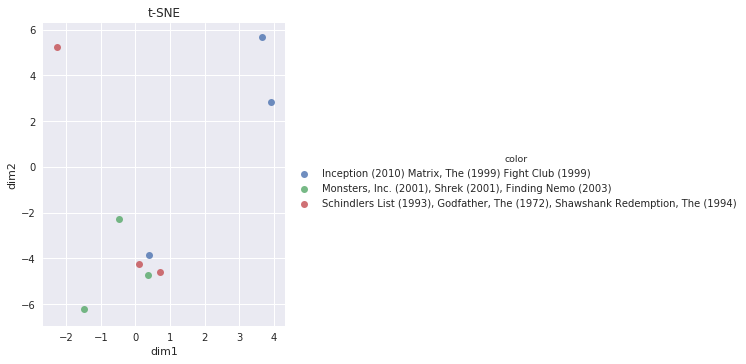

In [519]:
# Using the tsne with all the data
n_samples = 40
df_show1 = df_tsne[df_tsne.freq_seq == 'Inception (2010) Matrix, The (1999) Fight Club (1999)'].sample(n=3)
df_show2 = df_tsne[df_tsne.freq_seq == 'Monsters, Inc. (2001), Shrek (2001), Finding Nemo (2003)'].sample(n=3)
df_show3 = df_tsne[df_tsne.freq_seq == 'Schindlers List (1993), Godfather, The (1972), Shawshank Redemption, The (1994)'].sample(n=3)
df_show = pd.concat([df_show1 ,df_show2, df_show3])


df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=df_show['freq_seq']))
ax = sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('t-SNE')
plt.show()

# Plot some items that ocurre close to each other frequently

In [30]:
def times_elements_set_windows(all_sequences, sequence, windows_size):
    count = 0
    for seq in all_sequences:
        # Look if the first element is in the sequence
        if sequence[0] in seq:
            idx = seq.index(sequence[0])
            if (idx - windows_size)  >= 0:
                start_idx = idx - windows_size
            else:
                start_idx = 0
            if (idx + windows_size) < len(seq):
                end_idx = idx + windows_size
            else:
                end_idx = len(seq)
            windows_sequence = seq[start_idx:end_idx]
            #print('sequence:' + str(sequence))
            #print('windows_sequence:' + str(windows_sequence))
            if set(sequence).issubset(set(windows_sequence)):
                count += 1
                #print('yes')
    return count

ws = 5

look = ['1', '2', '4']
all_sequences = [['1', '2', '3', '4', '5'], ['1', '2', '10', '11', '12', '4'], ['0', '1', '2', '4', '10']]                    
print(times_elements_set_windows(all_sequences, look, ws))  
print('---------')
look = ['1', '8', '4']
all_sequences = [['1', '2', '3', '4', '5'], ['1', '2', '10', '11', '12', '4'], ['1', '2', '4']]                    
print(times_elements_set_windows(all_sequences, look, ws))  
print('---------')
look = ['1', '2', '3']
all_sequences = [['1', '2', '3', '4', '5'], ['1', '2', '10', '11', '12', '4'], ['1', '2', '4']]                    
print(times_elements_set_windows(all_sequences, look, ws))
print('---------')
look = ['4', '2', '1']
all_sequences = [['1', '2', '3', '4', '5'], ['1', '2', '10', '11', '12', '4'], ['1', '2', '4']]                    
print(times_elements_set_windows(all_sequences, look, ws))  

2
---------
0
---------
1
---------
3


In [18]:
# Create movie sequence
grouped = df_date.groupby('userId')

movie_sequences = []
i = 0
for name, group in grouped:
    # sorting by ratings
    movie_sequences.append(group.sort_values(['rating', 'date']).movieId.values.astype(str).tolist())
    i += 1

In [53]:
movie_id_look = '3949'
windows_size_side = 5
times_next = {}
times_previous = {}
for seq in movie_sequences:
    if movie_id_look in seq:
        idx = seq.index(movie_id_look)
        if (idx < (len(seq) - 3)) and (idx > 1):
            windows_movies_previous = seq[(idx-windows_size_side):idx]
            windows_movies_next = seq[(idx+1):(idx+1+windows_size_side)]
            for previous_movie in windows_movies_previous:
                if previous_movie in times_previous:
                    times_previous[previous_movie] += 1
                else:
                    times_previous[previous_movie] = 1
            for next_movie in windows_movies_next:
                if next_movie in times_next:
                    times_next[next_movie] += 1
                else:
                    times_next[next_movie] = 1
            
import operator
sorted_times_next = sorted(times_next.items(), key=operator.itemgetter(1))
sorted_times_previous = sorted(times_previous.items(), key=operator.itemgetter(1))
print(sorted_times_next[-5:])
print(sorted_times_previous[-5:])

[('47', 186), ('68157', 186), ('4011', 217), ('778', 285), ('4878', 289)]
[('4878', 236), ('296', 249), ('4226', 249), ('2959', 249), ('7361', 255)]


In [69]:
look = ['1258', '64614', '588']
ws = 10                    
times_elements_set_windows(movie_sequences, look, ws)  

7

In [67]:
df_date.movieId.value_counts()[90:99]

4011     6393
64614    6331
1036     6317
5618     6189
150      6174
3147     6170
1732     6122
1258     5999
588      5973
Name: movieId, dtype: int64

In [60]:
df_tsne[df_tsne.movie_id.isin(['8874', '69757', '293'])][['movie_id', 'title']] 

,movie_id,title
934,8874,Shaun of the Dead (2004)
1187,293,Léon: The Professional (a.k.a. The Professiona...
1587,69757,(500) Days of Summer (2009)


In [36]:
df_tsne.movie_id.dtype

dtype('int64')

In [61]:
movie_seq1 = ['79132', '74458', '68157'] # 124 ocurrences -> Inception (2010), Shutter Island (2010) Inglourious Basterds (2009)
movie_seq2 = ['2959', '2997', '2858'] # 149 ocurrences -> American Beauty (1999), Fight Club (1999), Being John Malkovich (1999)
movie_seq3 = ['4878', '3949', '7361'] # 162 ocurrences -> Donnie Darko (2001), Eternal Sunshine of the Spotless Mind (2004), Requiem for a Dream (2000)
movie_seq4 = ['8874', '69757', '293'] # 4 ocurrences

df_tsne['freq_seq'] = 'Null'
df_tsne.loc[df_tsne.movie_id.isin(movie_seq1), 'freq_seq'] = '124'
df_tsne.loc[df_tsne.movie_id.isin(movie_seq2), 'freq_seq'] = '149'
df_tsne.loc[df_tsne.movie_id.isin(movie_seq3), 'freq_seq'] = '162'
df_tsne.loc[df_tsne.movie_id.isin(movie_seq4), 'freq_seq'] = '4'


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


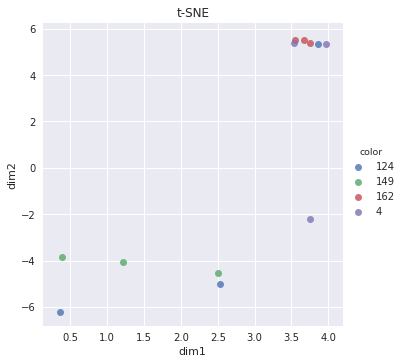

In [62]:
# Using the tsne with all the data
n_samples = 40
df_show1 = df_tsne[df_tsne.freq_seq == '124'].sample(n=3)
df_show2 = df_tsne[df_tsne.freq_seq == '149'].sample(n=3)
df_show3 = df_tsne[df_tsne.freq_seq == '162'].sample(n=3)
df_show4 = df_tsne[df_tsne.freq_seq == '4'].sample(n=3)
df_show = pd.concat([df_show1 ,df_show2, df_show3, df_show4])


df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=df_show['freq_seq']))
ax = sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('t-SNE')
plt.show()

# Better Experiment: Select a movie, and see which movies are close, print intensity in the scatter acording to the number of co-ocurrences, so the closest movies should have higher intensity

In [12]:
# Create movie sequence
grouped = df_date.groupby('userId')

movie_sequences = []
i = 0
for name, group in grouped:
    # sorting by ratings
    movie_sequences.append(group.sort_values(['rating', 'date']).movieId.values.astype(str).tolist())
    i += 1

In [13]:
# Compute number of times that a movie appears etween a windows size given another movie (coocurrences)

def count_coocurrences(movie_A, movie_B, sequences, windows_size):
    count = 0
    for seq in sequences:
        if (movie_A in seq) and (movie_B in seq):
            idx_A = seq.index(movie_A)
            idx_B = seq.index(movie_B)
            if np.abs(idx_A - idx_B) <= windows_size:
                count += 1
    return count
        

-3.12000617359 -4.33715876288


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


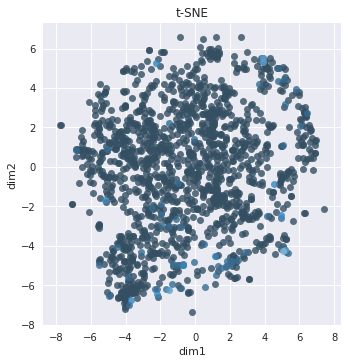

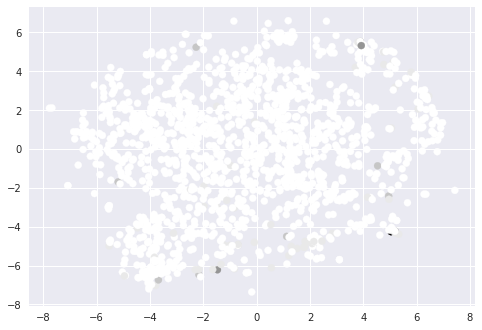

In [57]:
#primary_movies = ['58559', '318', '2571', '2959', '79132', '296', '356', '4993', '7153', '5952', '57706', '40494', '52378', '32022', '74657', '3648', '71817', '73879', '5003', '2098']
primary_movies = ['93748']

for p in primary_movies:
    w_size = 10
    primary_movie = p
    secondary_movies = df_tsne.movie_id.sample(1500)
    co_ocurrences = {}
    for m in secondary_movies:
        co_ocurrences[m] = 0
    for seq in movie_sequences:
        if primary_movie in seq:
            idx_A = seq.index(primary_movie)
            for m in secondary_movies:
                if m in seq:
                    idx_B = seq.index(m)
                    if np.abs(idx_A - idx_B) <= w_size:
                        co_ocurrences[m] += 1

    df_show1 = df_tsne[df_tsne.movie_id.isin(secondary_movies)]
    df_show2 = df_tsne[df_tsne.movie_id == p]
    x_movie = df_show2['x'].values[0]
    y_movie = df_show2['y'].values[0]
    df_show = pd.concat([df_show1 ,df_show2])
    df_show['co-ocurrences'] = 0
    df_show['co-ocurrences'] = df_show['movie_id'].map(co_ocurrences)
    df_show.loc[df_tsne.movie_id == p, 'co-ocurrences'] = 1
    df_show['is_item'] = 0
    df_show.loc[df_tsne.movie_id == p, 'is_item'] = 1
    print(x_movie, y_movie)

    from sklearn import preprocessing

    x = df_show['co-ocurrences'] #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)


    df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=x_scaled))
    ax = sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', palette="Blues_d", fit_reg=False, legend=False)
    #ax.fig.text(x_movie, y_movie, "movie", ha ='left', fontsize = 15)
    plt.title('t-SNE')
    plt.show()

    color = [str(item/255.) for item in df_show['co-ocurrences'].values]

    plt.scatter(df_show['x'], df_show['y'], c=x_scaled, s=50)#, cmap='gray')
    plt.show()


df_show.to_csv('df_show.csv')

In [20]:
df_show.to_csv('df_show.csv')

In [22]:
df_show[df_show.is_item==1]

,x,y,movie_id,title,genres,years,co-ocurrences,is_item
7598,0.596372,1.747165,40494,Zombie and the Ghost Train (Zombie ja Kummitus...,Comedy|Drama,0,1.0,1


In [23]:
df_show

,x,y,movie_id,title,genres,years,co-ocurrences,is_item
6,1.112534,-4.356299,110,Braveheart (1995),Action|Drama|War,1995,0.0,0
24,-0.088978,-4.806438,318,"Shawshank Redemption, The (1994)",Crime|Drama,1994,0.0,0
26,1.134862,-4.496661,356,Forrest Gump (1994),Comedy|Drama|Romance|War,1994,0.0,0
32,-5.413650,2.325179,405,Highlander III: The Sorcerer (a.k.a. Highlande...,Action|Fantasy,0,0.0,0
33,1.634709,-5.224406,410,Addams Family Values (1993),Children|Comedy|Fantasy,1993,0.0,0
36,6.193560,-2.387303,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,1993,0.0,0
40,6.565025,1.849085,531,"Secret Garden, The (1993)",Children|Drama,1993,0.0,0
49,0.829116,-4.412204,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,1991,0.0,0
61,6.286058,-2.306944,736,Twister (1996),Action|Adventure|Romance|Thriller,1996,0.0,0
69,6.414911,0.585957,968,Night of the Living Dead (1968),Horror|Sci-Fi|Thriller,1968,0.0,0


In [ ]:
x = np.random.random(10)
y = np.random.random(10)

plt.scatter(x, y, c=y, s=500, cmap='gray', x_scaled)

In [55]:
df_date.movieId.value_counts()[(df_date.movieId.value_counts() >= 23) &
                                                   (df_date.movieId.value_counts() < 24)]

93748     23
50898     23
75947     23
2512      23
3611      23
5836      23
6547      23
5353      23
73858     23
6382      23
5822      23
6515      23
823       23
59376     23
312       23
107436    23
8365      23
86762     23
97388     23
7821      23
8710      23
89000     23
4176      23
8201      23
31998     23
813       23
78856     23
26314     23
3956      23
50533     23
          ..
6195      23
4277      23
32211     23
100359    23
44949     23
115174    23
3344      23
94401     23
48049     23
31429     23
4272      23
32649     23
68        23
82848     23
5231      23
8676      23
108078    23
89377     23
62729     23
2095      23
8720      23
88069     23
105386    23
65243     23
2757      23
458       23
70970     23
5461      23
4675      23
109472    23
Name: movieId, dtype: int64

In [56]:
#df_tsne[df_tsne.movie_id.isin(['58559', '318', '2571', '2959', '79132', '296', '356', '4993', '7153', '5952', '57706', '40494', '52378', '32022', '74657', '3648', '71817', '73879', '5003', '2098', '50802'])][['movie_id', 'title']] 
df_tsne[df_tsne.movie_id == '93748']

,x,y,movie_id,title,genres,years
8192,-3.120006,-4.337159,93748,Eden of the East the Movie I: The King of Eden...,Action|Animation|Crime|Sci-Fi|Thriller,0


In [ ]:
# Using the tsne with all the data
n_samples = 40
df_show1 = df_tsne[df_tsne.freq_seq == '124'].sample(n=3)
df_show2 = df_tsne[df_tsne.freq_seq == '149'].sample(n=3)
df_show3 = df_tsne[df_tsne.freq_seq == '162'].sample(n=3)
df_show4 = df_tsne[df_tsne.freq_seq == '4'].sample(n=3)
df_show = pd.concat([df_show1 ,df_show2, df_show3, df_show4])


df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=df_show['freq_seq']))
ax = sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('t-SNE')
plt.show()

# Plot some of the top frequent sequences in the data

In [46]:
grouped = df_date.groupby('userId')

movie_sequences = []
i = 0
for name, group in grouped:
    # sorting by ratings
    movie_sequences.append(group.sort_values(['rating', 'date']).movieId.values.astype(str).tolist())
    i += 1

Sequence 1

In [59]:
times_next = {}
times_previous = {}
for seq in movie_sequences:
    if '58559' in seq:
        idx = seq.index('58559')
        if (idx < (len(seq) - 2)) and (idx > 0):
            next_movie = seq[idx+1]
            previous_movie = seq[idx-1]
            if next_movie in times_next:
                times_next[next_movie] += 1
            else:
                times_next[next_movie] = 1
            if previous_movie in times_previous:
                times_previous[previous_movie] += 1
            else:
                times_previous[previous_movie] = 1

In [64]:
#for key, value in times_next.items(): 6016 58559 2959
import operator
sorted_times_next = sorted(times_next.items(), key=operator.itemgetter(1))
sorted_times_previous = sorted(times_previous.items(), key=operator.itemgetter(1))

print(sorted_times_next[-1])
print(sorted_times_previous[-1])

('2959', 877)
('6016', 438)


In [75]:
# 6016 58559 2959
times_next_2959 = {}
times_previous_6016 = {}
for seq in movie_sequences:
    if '2959' in seq:
        idx = seq.index('2959')
        if (idx < (len(seq) - 2)) and (idx > 1):
            next_movie = seq[idx+1]
            # Check that the previous movie were the ones we are looking
            if (seq[idx - 1] == '58559') and (seq[idx - 2] == '6016'): 
                if next_movie in times_next_2959:
                    times_next_2959[next_movie] += 1
                else:
                    times_next_2959[next_movie] = 1
    if '6016' in seq:
        idx = seq.index('6016')
        if (idx < (len(seq) - 3)) and (idx > 0):
            next_movie = seq[idx+1]
            # Check that the next movies are the ones we are looking
            if (seq[idx + 1] == '58559') and (seq[idx + 2] == '2959'): 
                if previous_movie in times_previous_6016:
                    times_previous_6016[previous_movie] += 1
                else:
                    times_previous_6016[previous_movie] = 1

In [112]:
seq_look = ['6016', '58559', '2959']
num_times_seq = 0
for seq in movie_sequences:
    if seq_look[1] in seq:
        idx = seq.index(seq_look[1])
        if (idx < (len(seq) - 2)) and (idx > 0):
            next_movie = seq[idx+1]
            previous_movie = seq[idx-1]
            if (previous_movie == seq_look[0]) and (next_movie == seq_look[2]):
                num_times_seq += 1

In [113]:
num_times_seq

69

Sequence 2

In [120]:
times_next = {}
times_previous = {}
for seq in movie_sequences:
    if '2571' in seq:
        idx = seq.index('2571')
        if (idx < (len(seq) - 2)) and (idx > 0):
            next_movie = seq[idx+1]
            previous_movie = seq[idx-1]
            if next_movie in times_next:
                times_next[next_movie] += 1
            else:
                times_next[next_movie] = 1
            if previous_movie in times_previous:
                times_previous[previous_movie] += 1
            else:
                times_previous[previous_movie] = 1

In [121]:
#for key, value in times_next.items(): 2959 2571 260
import operator
sorted_times_next = sorted(times_next.items(), key=operator.itemgetter(1))
sorted_times_previous = sorted(times_previous.items(), key=operator.itemgetter(1))

print(sorted_times_next[-1])
print(sorted_times_previous[-1])

('260', 588)
('2959', 665)


In [123]:
seq_look = ['2959', '2571', '260']
num_times_seq = 0
for seq in movie_sequences:
    if seq_look[1] in seq:
        idx = seq.index(seq_look[1])
        if (idx < (len(seq) - 2)) and (idx > 0):
            next_movie = seq[idx+1]
            previous_movie = seq[idx-1]
            if (previous_movie == seq_look[0]) and (next_movie == seq_look[2]):
                num_times_seq += 1
print(num_times_seq)

63


Sequence 3

In [137]:
movie_id_look = '7153' 
times_next = {}
times_previous = {}
for seq in movie_sequences:
    if movie_id_look in seq:
        idx = seq.index(movie_id_look)
        if (idx < (len(seq) - 2)) and (idx > 0):
            next_movie = seq[idx+1]
            previous_movie = seq[idx-1]
            if next_movie in times_next:
                times_next[next_movie] += 1
            else:
                times_next[next_movie] = 1
            if previous_movie in times_previous:
                times_previous[previous_movie] += 1
            else:
                times_previous[previous_movie] = 1

In [138]:
#for key, value in times_next.items(): 2959 2571 260
import operator
sorted_times_next = sorted(times_next.items(), key=operator.itemgetter(1))
sorted_times_previous = sorted(times_previous.items(), key=operator.itemgetter(1))

print(sorted_times_next[-1])
print(sorted_times_previous[-1])

('5952', 2446)
('4993', 2792)


In [139]:
seq_look = ['4993', '7153', '5952']
num_times_seq = 0
for seq in movie_sequences:
    if seq_look[1] in seq:
        idx = seq.index(seq_look[1])
        if (idx < (len(seq) - 2)) and (idx > 0):
            next_movie = seq[idx+1]
            previous_movie = seq[idx-1]
            if (previous_movie == seq_look[0]) and (next_movie == seq_look[2]):
                num_times_seq += 1
print(num_times_seq)

1435


Sequence 4

In [223]:
movie_id_look = '5418' 
times_next = {}
times_previous = {}
for seq in movie_sequences:
    if movie_id_look in seq:
        idx = seq.index(movie_id_look)
        if (idx < (len(seq) - 2)) and (idx > 0):
            next_movie = seq[idx+1]
            previous_movie = seq[idx-1]
            if next_movie in times_next:
                times_next[next_movie] += 1
            else:
                times_next[next_movie] = 1
            if previous_movie in times_previous:
                times_previous[previous_movie] += 1
            else:
                times_previous[previous_movie] = 1

In [225]:
#for key, value in times_next.items(): 2959 2571 260
import operator
sorted_times_next = sorted(times_next.items(), key=operator.itemgetter(1))
sorted_times_previous = sorted(times_previous.items(), key=operator.itemgetter(1))

print(sorted_times_next[-1])
print(sorted_times_previous[-1])

('8665', 817)
('54286', 282)


In [229]:
seq_look = ['5418', '8665', '54286']
num_times_seq = 0
for seq in movie_sequences:
    if seq_look[1] in seq:
        idx = seq.index(seq_look[1])
        if (idx < (len(seq) - 2)) and (idx > 0):
            next_movie = seq[idx+1]
            previous_movie = seq[idx-1]
            if (previous_movie == seq_look[0]) and (next_movie == seq_look[2]):
                num_times_seq += 1
print(num_times_seq)

372


In [228]:
df_tsne[df_tsne.movie_id.isin(['8665', '5418', '54286'])]

,x,y,movie_id,title,genres,years,year_category,genre_1,genre_2,genre_3,saga,freq_seq
831,3.792037,5.700484,5418,"Bourne Identity, The (2002)",Action|Mystery|Thriller,2002,New (2000 or newer),Null,Null,Null,Null,Null
949,3.844866,5.614182,54286,"Bourne Ultimatum, The (2007)",Action|Crime|Thriller,2007,New (2000 or newer),Null,Null,Null,Null,Null
1058,3.912801,5.605086,8665,"Bourne Supremacy, The (2004)",Action|Crime|Thriller,2004,New (2000 or newer),Null,Null,Null,Null,Null


In [227]:
df_date.movieId.value_counts()[50:75]

44191    7797
8961     7745
5418     7701
68358    7670
69122    7649
4886     7511
1721     7348
1089     7332
1197     7310
1580     7270
4995     7239
780      7221
1221     7217
7438     7200
1704     7121
48780    7108
541      7101
56367    7057
5349     7031
48394    6934
364      6924
1214     6916
608      6898
3793     6830
5445     6778
Name: movieId, dtype: int64

Sequence 5 

In [188]:
movie_id_look = '1196' 
times_next = {}
times_previous = {}
for seq in movie_sequences:
    if movie_id_look in seq:
        idx = seq.index(movie_id_look)
        if (idx < (len(seq) - 2)) and (idx > 0):
            next_movie = seq[idx+1]
            previous_movie = seq[idx-1]
            if next_movie in times_next:
                times_next[next_movie] += 1
            else:
                times_next[next_movie] = 1
            if previous_movie in times_previous:
                times_previous[previous_movie] += 1
            else:
                times_previous[previous_movie] = 1

In [189]:
#for key, value in times_next.items(): 2959 2571 260
import operator
sorted_times_next = sorted(times_next.items(), key=operator.itemgetter(1))
sorted_times_previous = sorted(times_previous.items(), key=operator.itemgetter(1))

print(sorted_times_previous[-1])
print(sorted_times_next[-1])


('260', 1860)
('1210', 741)


In [237]:
seq_look = ['8957', '39446', '48877']
num_times_seq = 0
for seq in movie_sequences:
    if seq_look[1] in seq:
        idx = seq.index(seq_look[1])
        if (idx < (len(seq) - 2)) and (idx > 0):
            next_movie = seq[idx+1]
            previous_movie = seq[idx-1]
            if (previous_movie == seq_look[0]) and (next_movie == seq_look[2]):
                num_times_seq += 1
print(num_times_seq)

63


Sequence 6

In [335]:
movie_id_look = '593' 
times_next = {}
times_previous = {}
for seq in movie_sequences:
    if movie_id_look in seq:
        idx = seq.index(movie_id_look)
        if (idx < (len(seq) - 2)) and (idx > 0):
            next_movie = seq[idx+1]
            previous_movie = seq[idx-1]
            if next_movie in times_next:
                times_next[next_movie] += 1
            else:
                times_next[next_movie] = 1
            if previous_movie in times_previous:
                times_previous[previous_movie] += 1
            else:
                times_previous[previous_movie] = 1

In [336]:
#for key, value in times_next.items(): 2959 2571 260
import operator
sorted_times_next = sorted(times_next.items(), key=operator.itemgetter(1))
sorted_times_previous = sorted(times_previous.items(), key=operator.itemgetter(1))

print(sorted_times_previous[-1])
print(sorted_times_next[-1])


('356', 684)
('480', 434)


In [374]:
seq_look = ['1371', '1374', '1375']
num_times_seq = 0
for seq in movie_sequences:
    if seq_look[1] in seq:
        idx = seq.index(seq_look[1])
        if (idx < (len(seq) - 2)) and (idx > 0):
            next_movie = seq[idx+1]
            previous_movie = seq[idx-1]
            if (previous_movie == seq_look[0]) and (next_movie == seq_look[2]):
                num_times_seq += 1
print(num_times_seq)

1


In [373]:
#df_movies[df_movies['title'].str.contains("Casino Royale")] 49272
#df_movies[df_movies['title'].str.contains("Die Another Day")] 5872
#df_movies[df_movies['title'].str.lower().str.contains("is not enough")] 3082
#df_movies[df_movies['title'].str.lower().str.contains("goldeneye")] 10
#df_movies[df_movies['title'].str.lower().str.contains("superman returns")] 46530
#df_movies[df_movies['title'].str.lower().str.contains("the amazing")] 110553
#df_movies[df_movies['title'].str.lower().str.contains("spider-man")] 
df_tsne[df_tsne['title'].str.lower().str.contains("star trek")][['movie_id', 'title']] 

,movie_id,title
502,1371,Star Trek: The Motion Picture (1979)
757,102445,Star Trek Into Darkness (2013)
798,1372,Star Trek VI: The Undiscovered Country (1991)
988,1375,Star Trek III: The Search for Spock (1984)
989,1376,Star Trek IV: The Voyage Home (1986)
1292,68358,Star Trek (2009)
1907,1356,Star Trek: First Contact (1996)
1928,5944,Star Trek: Nemesis (2002)
2472,329,Star Trek: Generations (1994)
2571,1373,Star Trek V: The Final Frontier (1989)


In [357]:
df_tsne[df_tsne.movie_id == '81845'][['movie_id', 'title']] 

,movie_id,title
1126,81845,"King's Speech, The (2010)"


In [348]:
df_date.movieId.value_counts()[100:150]

74458    5927
293      5853
2997     5832
78499    5777
3949     5771
69757    5763
2716     5739
73017    5736
50872    5696
8874     5687
778      5675
1097     5649
2628     5641
81845    5625
1200     5600
8665     5570
60684    5455
71535    5427
924      5427
6365     5360
6502     5350
4896     5344
750      5343
1222     5320
912      5294
81591    5287
80463    5264
1208     5252
2502     5246
2918     5245
8368     5192
2291     5181
457      5168
367      5150
8636     5140
1961     5139
48774    5110
377      5054
3996     5046
4027     5035
6711     5033
3114     5033
2706     4967
89745    4958
500      4944
648      4911
68237    4864
7147     4858
35836    4834
4022     4834
Name: movieId, dtype: int64

In [190]:
df_tsne[df_tsne.movie_id == '106489']

,x,y,movie_id,title,genres,years,year_category,genre_1,genre_2,genre_3,saga,freq_seq
86,0.353249,-4.703336,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi,1983,Null,Null,Null,Null,Star Wars,Null


In [306]:
df_tsne[df_tsne.movie_id.isin(['858', '1221', '2023'])]

,x,y,movie_id,title,genres,years,year_category,genre_1,genre_2,genre_3,saga,freq_seq
67,0.869776,-3.988671,858,"Godfather, The (1972)",Crime|Drama,1972,Null,Null,Drama,Null,Null,Null
126,4.876545,3.871266,2023,"Godfather: Part III, The (1990)",Crime|Drama|Mystery|Thriller,1990,Null,Null,Null,Null,Null,Null
500,3.020465,-4.424275,1221,"Godfather: Part II, The (1974)",Crime|Drama,1974,Null,Null,Drama,Null,Null,Null


Get the movies and plot

In [375]:
seq1_movies = ['6016', '58559', '2959'] # 69 ocurrences (Fight Club (1999), City of God (Cidade de Deus) (2002), Dark Knight, The (2008))
seq2_movies = ['260', '1196', '1210'] # 439 ocurrences (Star wars)
seq3_movies = ['4993', '7153', '5952'] # 1435 ocurrences (Lord of the rings)
seq4_movies = ['5418', '8665', '54286'] # 372 ocurrences (Bourne)
seq5_movies = ['113278', '110553', '102154'] #(Batman, superman, spiderman)
seq6_movies = ['1', '3114', '78499'] #(Toy Story)
seq7_movies = ['2571', '6365', '6934'] #(Matrix)


df_tsne['freq_seq'] = 'Null'
df_tsne.loc[df_tsne.movie_id.isin(seq1_movies), 'freq_seq'] = 'Frequent sequence 1'
df_tsne.loc[df_tsne.movie_id.isin(seq2_movies), 'freq_seq'] = 'Star Wars'
df_tsne.loc[df_tsne.movie_id.isin(seq3_movies), 'freq_seq'] = 'Lord of the Rings'
df_tsne.loc[df_tsne.movie_id.isin(seq4_movies), 'freq_seq'] = 'Bourne'
df_tsne.loc[df_tsne.movie_id.isin(seq5_movies), 'freq_seq'] = 'Batman, superman, spiderman'
df_tsne.loc[df_tsne.movie_id.isin(seq6_movies), 'freq_seq'] = 'Toy Story'



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


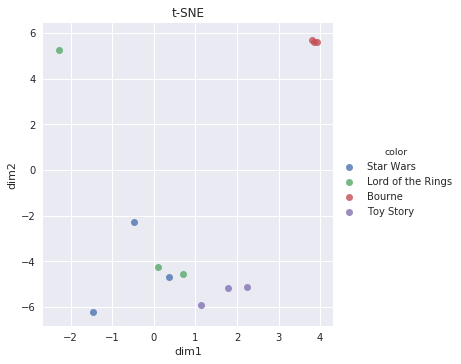

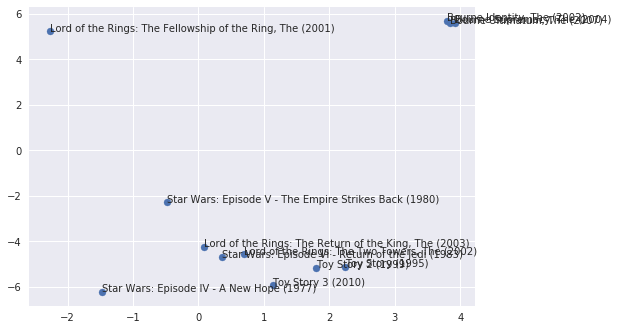

In [376]:
# Using the tsne with all the data
n_samples = 40
df_show1 = df_tsne[df_tsne.freq_seq == 'Frequent sequence 1'].sample(n=3)
df_show2 = df_tsne[df_tsne.freq_seq == 'Star Wars'].sample(n=3)
df_show3 = df_tsne[df_tsne.freq_seq == 'Lord of the Rings'].sample(n=3)
df_show4 = df_tsne[df_tsne.freq_seq == 'Bourne'].sample(n=3)
df_show5 = df_tsne[df_tsne.freq_seq == 'Batman, superman, spiderman'].sample(n=3)
df_show6 = df_tsne[df_tsne.freq_seq == 'Toy Story'].sample(n=3)
df_show = pd.concat([df_show2 ,df_show3, df_show4, df_show6])


df_plot = pd.DataFrame(dict(dim1=df_show['x'], dim2=df_show['y'], color=df_show['freq_seq']))
ax = sns.lmplot('dim1', 'dim2', data=df_plot, hue='color', fit_reg=False)
plt.title('t-SNE')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df_show['x'], df_show['y'])

for i, txt in enumerate(df_show['title']):
    ax.annotate(txt, (df_show['x'].iloc[i], df_show['y'].iloc[i]), fontsize=10)
fig.savefig('scatter_annotations.png')
plt.show()

# TSNE plot per number of ocurrences

In [80]:
movie_counts = df_date.movieId.value_counts().to_dict()
df_tsne['movie_count'] = df_tsne['movie_id'].astype(int).map(movie_counts)
df_tsne.to_csv('df_tsne.csv')